In [1]:
#Import necessary libraries
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as LinReg
from sklearn.utils import resample


#Regression class
class regression():
    def __init__(self, complexity: int, seed: int):
        
        self.complexity = complexity
        
        self.rng = np.random.default_rng(seed=seed)
        self.seed = seed
    
        #Get the Boston housing data
        self.url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
        self.dataframe = read_csv(self.url, header=None)
        #Separate the data into X and y
        self.data = self.dataframe.values
        self.X, self.y = self.data[:, :-1], self.data[:, -1]
        #Split into train and test data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.25, random_state=seed)

    
    #Linear Regression
    def bootstrap_ols(self, degree: int, max_bootstrap_cycle: int, n_val, lamb: float = 0, alpha: float = 0):

        #Limiting X data depending on complexity
        X_train = self.X_train[:, :degree]
        X_test = self.X_test[:, :degree]
            
        #Bootstrap cycles
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            #Resampling of data
            X_train_resampled, y_train_resampled = resample(X_train, self.y_train, random_state=seed * bootstrap_cycle)

            #Ridge regression if lamb is not 0
            if not lamb == 0:
                ridge = LinReg.Ridge(alpha=lamb, random_state=seed)
                #Bias-variance decomposition using mlxtend
                mse, bias, var = bias_variance_decomp(ridge, X_train_resampled, y_train_resampled, X_test, self.y_test, loss='mse', num_rounds=n_val, random_seed=seed)
                
            #Lasso regression if lamb is not 0
            elif not alpha == 0:
                lasso = LinReg.Lasso(alpha=alpha, random_state=seed)
                mse, bias, var = bias_variance_decomp(lasso, X_train_resampled, y_train_resampled, X_test, self.y_test, loss='mse', num_rounds=n_val, random_seed=seed)
        
            #Ordinary Least Squares otherwise
            else: 
                ols = LinReg.LinearRegression()
                mse, bias, var = bias_variance_decomp(ols, X_train_resampled, y_train_resampled, X_test, self.y_test, loss='mse', num_rounds=n_val, random_seed=seed)
        
        return mse/100, bias/100, var/100
    
    #Decision Tree
    def dt(self, degree: int, max_bootstrap_cycle: int, n_val):
        
        #Setting up the data
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        
        
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=seed * bootstrap_cycle)
            tree = DecisionTreeRegressor(random_state=seed)
            #Fit the resampled data into the decision tree model
            tree.fit(X_train_resampled, y_train_resampled)

            complexity = degree
            degrees = np.arange(1, complexity + 1)
            mse = np.zeros(complexity)
            bias = np.zeros(complexity)
            var = np.zeros(complexity)
            for i, deg in enumerate(degrees):
                X_train_fs = X_train_resampled[:, :deg]
                X_test_fs = X_test[:, :deg]
                mse[i], bias[i], var[i] = bias_variance_decomp(tree, X_train_fs, y_train_resampled, X_test_fs, y_test, loss='mse', num_rounds=n_val, random_seed=seed)
            
            print(f"Bootstrap cycle: {1 + bootstrap_cycle}")
                        
        return mse/100, bias/100, var/100
    
    #Neural Network
    def nn(self, degree: int, max_bootstrap_cycle: int, n_val):
        
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=seed * bootstrap_cycle)
        
            complexity = degree
            degrees = np.arange(1, complexity + 1)
            mse = np.zeros(complexity)
            bias = np.zeros(complexity)
            var = np.zeros(complexity)
            for i, deg in enumerate(degrees):
                nn = MLPRegressor(random_state=seed, hidden_layer_sizes=deg, tol=1e-1, max_iter=1000)
                nn.fit(X_train_resampled, y_train_resampled)
                mse[i], bias[i], var[i] = bias_variance_decomp(nn, X_train_resampled, y_train_resampled, X_test, y_test, loss='mse', num_rounds=n_val, random_seed=seed)
                print(f"Complexity: {deg}")
            print(f"Bootstrap cycle: {1 + bootstrap_cycle}")
            
        return mse/100, bias/100, var/100
    
    #Randon Forest
    def rf(self, degree: int, max_bootstrap_cycle: int, n_val):
        
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        
        
        for bootstrap_cycle in range(max_bootstrap_cycle):
            
            X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=seed * bootstrap_cycle)
            tree = RandomForestRegressor(random_state=seed)
            tree.fit(X_train_resampled, y_train_resampled)

            complexity = degree
            degrees = np.arange(1, complexity + 1)
            mse = np.zeros(complexity)
            bias = np.zeros(complexity)
            var = np.zeros(complexity)
            for i, deg in enumerate(degrees):
                X_train_fs = X_train_resampled[:, :deg]
                X_test_fs = X_test[:, :deg]
                mse[i], bias[i], var[i] = bias_variance_decomp(tree, X_train_fs, y_train_resampled, X_test_fs, y_test, loss='mse', num_rounds=n_val, random_seed=seed)
                print(f"Complexity: {deg}")
            print(f"Bootstrap cycle: {1 + bootstrap_cycle}")
                        
        return mse/100, bias/100, var/100
    
#Seed
seed = 3754
#seed = np.random.integers(0, 5000)
#print(seed)

#Number of rounds for bias-variance decomposition
n_val = [200]
#Number of bootstrap cycles
max_bootstrap_cycle = [1, 25, 50, 100]
#Level of complexity
complexity = 12
degrees = np.arange(1, complexity + 1)

#RNG
rng = np.random.default_rng(seed=seed)

#Regression
reg = regression(complexity, seed)


In [ ]:
#Performing bootstrap on standard OLS
    
mse = np.zeros(complexity)
bias = np.zeros(complexity)
var = np.zeros(complexity)

for i, deg in enumerate(degrees):
    mse[i], bias[i], var[i] = reg.bootstrap_ols(degree=deg, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0], lamb=0, alpha=0)
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

        
plt.figure(0)
plt.title("Variance, bias on OLS")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_ols', dpi=300)
plt.show()


MSE: 0.719275330036289, Bias: 0.7164670038675479, Variance: 0.002808326168740929, Complexity: 1
MSE: 0.642128442627884, Bias: 0.6377388877243945, Variance: 0.0043895549034896255, Complexity: 2
MSE: 0.57684433125953, Bias: 0.570884219446115, Variance: 0.005960111813415357, Complexity: 3
MSE: 0.5476595048299425, Bias: 0.5369209805990571, Variance: 0.010738524230885471, Complexity: 4
MSE: 0.5494142830212999, Bias: 0.5377979424763117, Variance: 0.011616340544988207, Complexity: 5
MSE: 0.24451406909265216, Bias: 0.23344526120994152, Variance: 0.011068807882710762, Complexity: 6
MSE: 0.24465603792395058, Bias: 0.23271209059961895, Variance: 0.011943947324331653, Complexity: 7
MSE: 0.21465188723815065, Bias: 0.2036019466245718, Variance: 0.011049940613578904, Complexity: 8
MSE: 0.21563614896043465, Bias: 0.20280464080801106, Variance: 0.01283150815242361, Complexity: 9
MSE: 0.21351815364558696, Bias: 0.20042267348250406, Variance: 0.013095480163083081, Complexity: 10
MSE: 0.2360636457658029, 

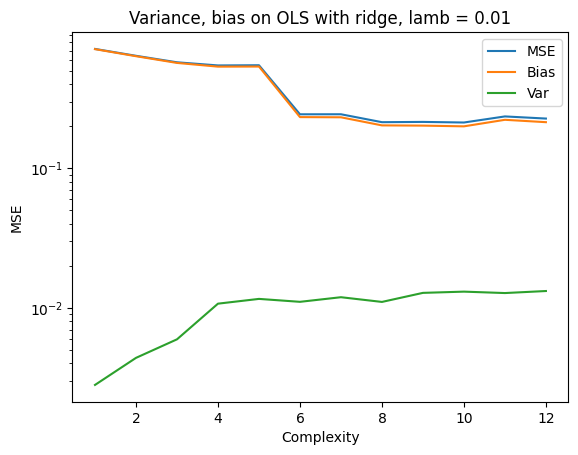

In [6]:
#OLS with Ridge

lamb = 0.01

    
mse = np.zeros(complexity)
bias = np.zeros(complexity)
var = np.zeros(complexity)

for i, deg in enumerate(degrees):
    mse[i], bias[i], var[i] = reg.bootstrap_ols(degree=deg, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0], lamb=lamb, alpha=0)
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")
    
        
plt.figure(0)
plt.title(f"Variance, bias on OLS with ridge, lamb = {lamb}")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_ridge', dpi=300)
plt.show()

MSE: 0.7192918723235477, Bias: 0.7164841666999904, Variance: 0.002807705623557395, Complexity: 1
MSE: 0.6421406368665029, Bias: 0.6377514644745116, Variance: 0.0043891723919913745, Complexity: 2
MSE: 0.5768686540747744, Bias: 0.5709088503178811, Variance: 0.005959803756893648, Complexity: 3
MSE: 0.5479404647986427, Bias: 0.5372060332764247, Variance: 0.01073443152221821, Complexity: 4
MSE: 0.5489862338112816, Bias: 0.5378270669922073, Variance: 0.011159166819074, Complexity: 5
MSE: 0.24580516859940305, Bias: 0.23504507650015655, Variance: 0.010760092099246448, Complexity: 6
MSE: 0.2449328035802529, Bias: 0.23367605270247313, Variance: 0.01125675087777976, Complexity: 7
MSE: 0.2167103755760317, Bias: 0.2057180854411736, Variance: 0.010992290134858035, Complexity: 8
MSE: 0.21758498044926372, Bias: 0.20508280030887235, Variance: 0.012502180140391513, Complexity: 9
MSE: 0.2153759695082957, Bias: 0.20261093576879113, Variance: 0.012765033739504564, Complexity: 10
MSE: 0.23597300597501725, B

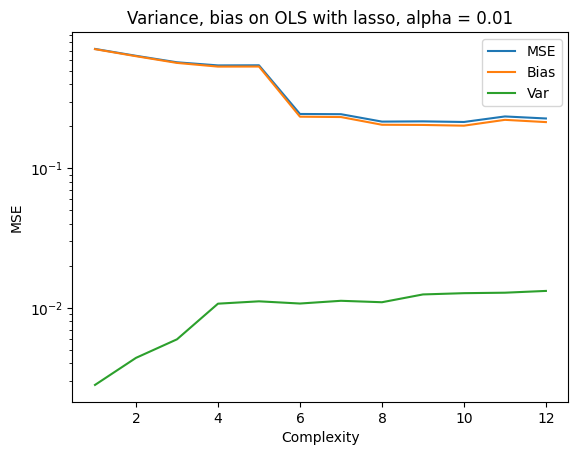

In [5]:
#OLS with Lasso

alpha = 0.01

    
mse = np.zeros(complexity)
bias = np.zeros(complexity)
var = np.zeros(complexity)

for i, deg in enumerate(degrees):
    mse[i], bias[i], var[i] = reg.bootstrap_ols(degree=deg, max_bootstrap_cycle=max_bootstrap_cycle[2], n_val=n_val[0], lamb=0, alpha=alpha)
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")
    
        
plt.figure(0)
plt.title(f"Variance, bias on OLS with lasso, alpha = {alpha}")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_lasso', dpi=300)
plt.show()

Bootstrap cycle: 1
Bootstrap cycle: 2
Bootstrap cycle: 3
Bootstrap cycle: 4
Bootstrap cycle: 5
Bootstrap cycle: 6
Bootstrap cycle: 7
Bootstrap cycle: 8
Bootstrap cycle: 9
Bootstrap cycle: 10
Bootstrap cycle: 11
Bootstrap cycle: 12
Bootstrap cycle: 13
Bootstrap cycle: 14
Bootstrap cycle: 15
Bootstrap cycle: 16
Bootstrap cycle: 17
Bootstrap cycle: 18
Bootstrap cycle: 19
Bootstrap cycle: 20
Bootstrap cycle: 21
Bootstrap cycle: 22
Bootstrap cycle: 23
Bootstrap cycle: 24
Bootstrap cycle: 25
Bootstrap cycle: 26
Bootstrap cycle: 27
Bootstrap cycle: 28
Bootstrap cycle: 29
Bootstrap cycle: 30
Bootstrap cycle: 31
Bootstrap cycle: 32
Bootstrap cycle: 33
Bootstrap cycle: 34
Bootstrap cycle: 35
Bootstrap cycle: 36
Bootstrap cycle: 37
Bootstrap cycle: 38
Bootstrap cycle: 39
Bootstrap cycle: 40
Bootstrap cycle: 41
Bootstrap cycle: 42
Bootstrap cycle: 43
Bootstrap cycle: 44
Bootstrap cycle: 45
Bootstrap cycle: 46
Bootstrap cycle: 47
Bootstrap cycle: 48
Bootstrap cycle: 49
Bootstrap cycle: 50
MSE: 0.96

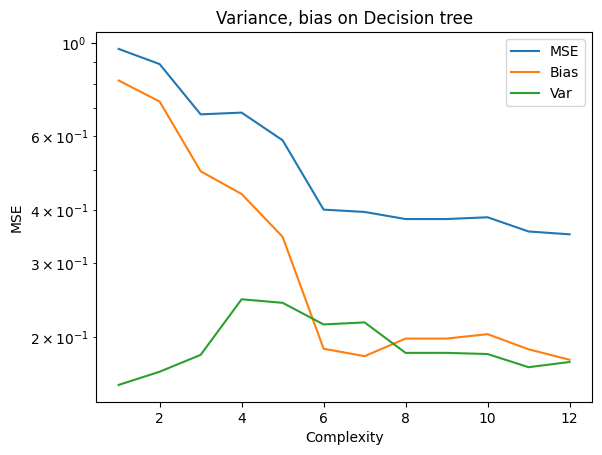

In [2]:
#Descision tree
mse, bias, var = reg.dt(degree=complexity, max_bootstrap_cycle=50, n_val=n_val[0])

for i in range(complexity):
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

plt.figure(0)
plt.title(f"Variance, bias on Decision tree")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_dt', dpi=300)
plt.show()

In [ ]:
#Random forest
mse, bias, var = reg.rf(degree=complexity, max_bootstrap_cycle=5, n_val=n_val[0])

for i in range(complexity):
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

plt.figure(0)
plt.title(f"Variance, bias on Random forest")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_rf', dpi=300)
plt.show()

Complexity: 1
Complexity: 2
Complexity: 3
Complexity: 4
Complexity: 5
Complexity: 6
Complexity: 7
Complexity: 8
Complexity: 9
Complexity: 10
Complexity: 11
Complexity: 12
Bootstrap cycle: 1
Complexity: 1
Complexity: 2
Complexity: 3
Complexity: 4
Complexity: 5
Complexity: 6
Complexity: 7
Complexity: 8
Complexity: 9
Complexity: 10
Complexity: 11
Complexity: 12
Bootstrap cycle: 2
Complexity: 1
Complexity: 2
Complexity: 3
Complexity: 4
Complexity: 5
Complexity: 6
Complexity: 7
Complexity: 8
Complexity: 9
Complexity: 10
Complexity: 11
Complexity: 12
Bootstrap cycle: 3
Complexity: 1
Complexity: 2
Complexity: 3
Complexity: 4
Complexity: 5
Complexity: 6
Complexity: 7
Complexity: 8
Complexity: 9
Complexity: 10
Complexity: 11
Complexity: 12
Bootstrap cycle: 4
Complexity: 1
Complexity: 2
Complexity: 3
Complexity: 4
Complexity: 5
Complexity: 6
Complexity: 7
Complexity: 8
Complexity: 9
Complexity: 10
Complexity: 11
Complexity: 12
Bootstrap cycle: 5
MSE: 5.244165247351269, Bias: 5.243562403851569, V

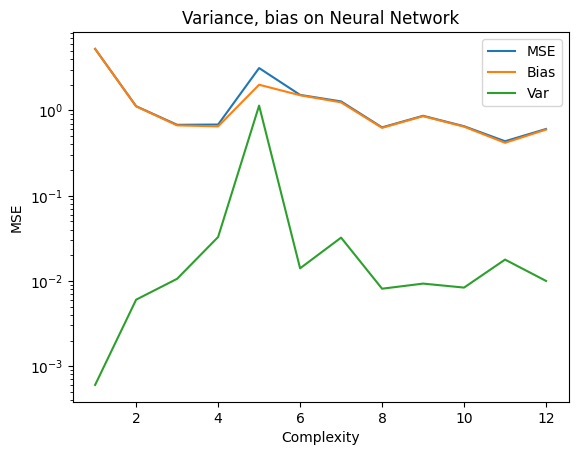

In [2]:
#Neural network
mse, bias, var = reg.nn(degree=complexity, max_bootstrap_cycle=5, n_val=n_val[0])
    
for i in range(complexity):
    print(f"MSE: {mse[i]}, Bias: {bias[i]}, Variance: {var[i]}, Complexity: {degrees[i]}")

plt.figure(0)
plt.title(f"Variance, bias on Neural Network")
plt.yscale('log')
plt.plot(degrees, mse, label="MSE")
plt.plot(degrees, bias, label="Bias")
plt.plot(degrees, var, label="Var")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend()
plt.savefig('add_nn', dpi=300)
plt.show()